<a href="https://colab.research.google.com/github/arihantkode/BrainTumorSegmentation/blob/main/unet_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 119.5 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn

In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp '/content/gdrive/MyDrive/Brain_Tumour_Segmentation/MICCAI_BraTS_2018_Data_Training.zip' '/content/'

In [ ]:
!unzip /content/MICCAI_BraTS_2018_Data_Training.zip

Archive:  /content/MICCAI_BraTS_2018_Data_Training.zip
   creating: MICCAI_BraTS_2018_Data_Training/
  inflating: __MACOSX/._MICCAI_BraTS_2018_Data_Training  
  inflating: MICCAI_BraTS_2018_Data_Training/.DS_Store  
  inflating: __MACOSX/MICCAI_BraTS_2018_Data_Training/._.DS_Store  
   creating: MICCAI_BraTS_2018_Data_Training/training/
  inflating: __MACOSX/MICCAI_BraTS_2018_Data_Training/._training  
  inflating: MICCAI_BraTS_2018_Data_Training/survival_data.csv  
  inflating: __MACOSX/MICCAI_BraTS_2018_Data_Training/._survival_data.csv  
  inflating: MICCAI_BraTS_2018_Data_Training/training/.DS_Store  
  inflating: __MACOSX/MICCAI_BraTS_2018_Data_Training/training/._.DS_Store  
   creating: MICCAI_BraTS_2018_Data_Training/training/HGG/
  inflating: __MACOSX/MICCAI_BraTS_2018_Data_Training/training/._HGG  
   creating: MICCAI_BraTS_2018_Data_Training/training/LGG/
  inflating: __MACOSX/MICCAI_BraTS_2018_Data_Training/training/._LGG  
   creating: MICCAI_BraTS_2018_Data_Training/train

In [ ]:
import os
# Set the environment variable before importing any CUDA-dependent libraries
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
import json
import random
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from typing import Tuple, Optional, Dict, List
from nilearn import plotting, image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from datetime import datetime

# Data Preprocessing

In [ ]:
hgg_data_folder = '/content/MICCAI_BraTS_2018_Data_Training/training/HGG'
t1_pattern = os.path.join(hgg_data_folder, f"**/*t1.nii")
t1ce_pattern = os.path.join(hgg_data_folder, f"**/*t1ce.nii")
t2_pattern = os.path.join(hgg_data_folder, f"**/*t2.nii")
flair_pattern = os.path.join(hgg_data_folder, f"**/*flair.nii")
seg_pattern = os.path.join(hgg_data_folder, f"**/*seg.nii")

t1_files = glob.glob(t1_pattern)
t1ce_files = glob.glob(t1ce_pattern)
t2_files = glob.glob(t2_pattern)
flair_files = glob.glob(flair_pattern)
seg_files = glob.glob(seg_pattern)
all_files = np.array([t1_files, t2_files, t1ce_files, flair_files, seg_files]).T
all_files = pd.DataFrame(all_files, columns=['t1', 't2', 't1ce', 'flair', 'label'])

print(f"example: {all_files['t1'][0]}")
print(f"shape of all files : {all_files.shape}")
print(f"Number of t1 files: {len(t1_files)}")
print(f"Number of t1ce files: {len(t1ce_files)}")
print(f"Number of t2 files: {len(t2_files)}")
print(f"Number of flair files: {len(flair_files)}")
print(f"Number of seg files: {len(seg_files)}")

In [ ]:
train_set, test_set = train_test_split(all_files, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_set, test_size=0.1, random_state=42)
print(f"shape of train set : {train_set.shape}")
print(f"shape of test set : {test_set.shape}")
print(f"shape of validation set : {val_set.shape}")

In [ ]:
t1_train = train_set['t1']
t2_train = train_set['t2']
t1ce_train = train_set['t1ce']
flair_train = train_set['flair']
labels_train = train_set['label']

t1_test = test_set['t1']
t2_test = test_set['t2']
t1ce_test = test_set['t1ce']
flair_test = test_set['flair']
labels_test = test_set['label']

print(f"t1 train shape : {t1_train.shape}, t1 test shape : {t1_test.shape}")

In [ ]:
t1_train_imgs = [nib.load(img).get_fdata() for img in t1_train[:20]]
train_labels_imgs = [nib.load(img).get_fdata() for img in labels_train[:20]]
print(f"image shape = {train_labels_imgs[0].shape}")
print(f"unique labels = {np.unique(train_labels_imgs[0])}")
print(f"header = {nib.load(t1_train[0]).header}")
plotting.plot_roi(nib.load(labels_train[0]), nib.load(t1_train[0]), cmap='Paired')
plt.show()
t1_train_imgs = np.array(t1_train_imgs)
train_labels_imgs = np.array(train_labels_imgs)
t1_train_imgs = t1_train_imgs.reshape(-1, 240, 240)
train_labels_imgs = train_labels_imgs.reshape(-1, 240, 240)
print(f"t1 train shape : {t1_train_imgs.shape}")
print(f"train labels shape : {train_labels_imgs.shape}")

slice_idx = 60
plt.imshow(t1_train_imgs[slice_idx], cmap='gray')
plt.title(f"t1 train slice = {slice_idx - 1}")
plt.show()
plt.imshow(train_labels_imgs[slice_idx], cmap='gray')
plt.show()

In [ ]:
class DoubleConv(nn.Module):
    """
    Double convolution block with batch normalization and ReLU activation.
    This is the basic building block used throughout the UNet architecture.
    """

    def __init__(self, in_channels: int, out_channels: int, mid_channels: Optional[int] = None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.double_conv(x)


class Down(nn.Module):
    """
    Downsampling block: maxpool followed by double convolution.
    Reduces spatial dimensions by half and increases channel depth.
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.maxpool_conv(x)


class Up(nn.Module):
    """
    Upsampling block: upsampling followed by double convolution.
    Increases spatial dimensions by factor of 2 and decreases channel depth.
    """

    def __init__(self, in_channels: int, out_channels: int, bilinear: bool = True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
        x1 = self.up(x1)

        # Handle input size differences
        diff_y = x2.size()[2] - x1.size()[2]
        diff_x = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diff_x // 2, diff_x - diff_x // 2,
                        diff_y // 2, diff_y - diff_y // 2])

        # Concatenate along channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    """
    Output convolution layer that maps to the desired number of output channels.
    """

    def __init__(self, in_channels: int, out_channels: int):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.conv(x)


class UNet(nn.Module):
    """
    UNet architecture for brain tumor segmentation.

    Architecture:
    - Input: 240x240 MRI slice
    - Encoder: 4 downsampling blocks with skip connections
    - Bottleneck: Double convolution at the deepest level
    - Decoder: 4 upsampling blocks with skip connections
    - Output: 240x240 segmentation mask

    Args:
        n_channels: Number of input channels (default: 1 for grayscale MRI)
        n_classes: Number of output classes (default: 4 for BraTS: background, necrosis, edema, enhancing)
        bilinear: Whether to use bilinear upsampling (default: True)
        dropout_rate: Dropout rate for regularization (default: 0.1)
    """

    def __init__(self, n_channels: int = 1, n_classes: int = 4, bilinear: bool = True, dropout_rate: float = 0.1, device: str = 'auto'):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Device handling
        if device == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(device)

        # Move model to device
        self.to(self.device)

        # Encoder path (downsampling)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)

        # Bottleneck
        self.bottleneck = DoubleConv(1024 // factor, 1024 // factor)

        # Decoder path (upsampling)
        # up1: bottleneck(512) + skip(512) = 1024 input channels
        self.up1 = Up(1024 // factor + 512, 512 // factor, bilinear)
        # up2: up1_output(256) + skip(256) = 512 input channels
        self.up2 = Up(512 // factor + 256, 256 // factor, bilinear)
        # up3: up2_output(128) + skip(128) = 256 input channels
        self.up3 = Up(256 // factor + 128, 128 // factor, bilinear)
        # up4: up3_output(64) + skip(64) = 128 input channels
        self.up4 = Up(128 // factor + 64, 64, bilinear)

        # Output layer
        self.outc = OutConv(64, n_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout2d(dropout_rate)

        # Initialize weights
        self._initialize_weights()

    def get_device(self) -> torch.device:
        """Get the device the model is on."""
        return self.device

    def to_device(self, device: str) -> 'UNet':
        """Move model to specified device."""
        self.device = torch.device(device)
        return self.to(self.device)

    def _initialize_weights(self):
        """Initialize model weights using Xavier/Glorot initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the UNet.

        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
               Expected input size: (B, 1, 240, 240)

        Returns:
            Output tensor of shape (batch_size, n_classes, height, width)
            Output size: (B, 4, 240, 240)
        """
        # Ensure input is on the correct device
        if x.device != self.device:
            x = x.to(self.device)
        # Encoder path with skip connections
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Apply dropout at bottleneck
        x5 = self.dropout(x5)
        x5 = self.bottleneck(x5)

        # Decoder path with skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        # Output layer
        logits = self.outc(x)

        return logits

In [ ]:
def get_model_summary(model: nn.Module, input_size: Tuple[int, int, int, int] = (1, 1, 240, 240)) -> str:
    """
    Generate a summary of the model architecture.

    Args:
        model: PyTorch model
        input_size: Input tensor size (batch_size, channels, height, width)

    Returns:
        String containing model summary
    """
    def register_hook(module):
        def hook(module, input, output):
            class_name = str(module.__class__).split(".")[-1].split("'")[0]
            module_idx = len(summary)

            m_key = f"{class_name}-{module_idx + 1}"
            summary[m_key] = OrderedDict()
            summary[m_key]["module_name"] = class_name
            summary[m_key]["input_shape"] = list(input[0].size())
            summary[m_key]["output_shape"] = list(output.size())
            summary[m_key]["num_params"] = sum(p.numel() for p in module.parameters())

        hooks.append(module.register_forward_hook(hook))

    # Create OrderedDict to store summary
    from collections import OrderedDict
    summary = OrderedDict()
    hooks = []

    # Register hook
    model.apply(register_hook)

    # Make a forward pass
    x = torch.zeros(input_size).to(next(model.parameters()).device)
    model(x)

    # Remove hooks
    for h in hooks:
        h.remove()

    # Generate summary string
    summary_str = f"{'='*80}\n"
    summary_str += f"{'UNet Model Summary':^80}\n"
    summary_str += f"{'='*80}\n"
    summary_str += f"{'Layer (type)':<25} {'Output Shape':<25} {'Param #':<15}\n"
    summary_str += f"{'='*80}\n"

    total_params = 0
    for layer in summary:
        summary_str += f"{summary[layer]['module_name']:<25} "
        summary_str += f"{str(summary[layer]['output_shape']):<25} "
        summary_str += f"{summary[layer]['num_params']:<15}\n"
        total_params += summary[layer]["num_params"]

    summary_str += f"{'='*80}\n"
    summary_str += f"Total params: {total_params:,}\n"
    summary_str += f"Trainable params: {total_params:,}\n"
    summary_str += f"{'='*80}\n"

    return summary_str

In [ ]:
class BraTSDataset(Dataset):
    """
    Dataset class for BraTS brain tumor segmentation data.
    Loads MRI slices and corresponding segmentation masks.
    """

    def __init__(self, data_dir: str, transform=None, slice_range: Optional[Tuple[int, int]] = None,
                 patient_dirs: Optional[List[Path]] = None, modality: str = 't1'):
        """
        Initialize BraTS dataset.

        Args:
            data_dir: Directory containing BraTS data
            transform: Optional transforms to apply
            slice_range: Tuple of (start, end) slice indices to use (None for single middle slice)
            patient_dirs: Optional list of specific patient directories to use (for train/val/test splits)
            modality: MRI modality to use ('t1', 't1ce', 't2', 'flair')
        """
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.slice_range = slice_range
        self.modality = modality.lower()

        if patient_dirs is not None:
            # Use provided patient directories (for train/val/test splits)
            self.patient_dirs = patient_dirs
        else:
            # Find all patient directories
            self.patient_dirs = []
            for patient_dir in self.data_dir.iterdir():
                if patient_dir.is_dir() and patient_dir.name.startswith('Brats18'):
                    self.patient_dirs.append(patient_dir)

        print(f"Found {len(self.patient_dirs)} patient directories")

        # Validate data structure
        self._validate_data()

    def _validate_data(self):
        """Validate that required files exist for each patient."""
        valid_patients = []

        for patient_dir in self.patient_dirs:
            # Check for required files
            modality_file = patient_dir / f"{patient_dir.name}_{self.modality}.nii"
            seg_file = patient_dir / f"{patient_dir.name}_seg.nii"

            if modality_file.exists() and seg_file.exists():
                valid_patients.append(patient_dir)
            else:
                print(f"Warning: Missing {self.modality} or seg files for {patient_dir.name}")

        self.patient_dirs = valid_patients
        print(f"Valid patients with {self.modality.upper()} modality: {len(self.patient_dirs)}")

    def __len__(self) -> int:
        if self.slice_range is None:
            return len(self.patient_dirs)
        else:
            # Each patient contributes (end - start) slices
            return len(self.patient_dirs) * (self.slice_range[1] - self.slice_range[0])

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """Get MRI slice and segmentation mask for a patient."""
        if self.slice_range is None:
            # Single slice mode (original behavior)
            patient_dir = self.patient_dirs[idx]
            patient_idx = idx
            slice_idx = None
        else:
            # Multiple slices mode
            slices_per_patient = self.slice_range[1] - self.slice_range[0]
            patient_idx = idx // slices_per_patient
            slice_offset = idx % slices_per_patient
            slice_idx = self.slice_range[0] + slice_offset
            patient_dir = self.patient_dirs[patient_idx]

        # Load modality image
        modality_file = patient_dir / f"{patient_dir.name}_{self.modality}.nii"
        modality_img = nib.load(str(modality_file))
        modality_data = modality_img.get_fdata()

        # Load segmentation mask
        seg_file = patient_dir / f"{patient_dir.name}_seg.nii"
        seg_img = nib.load(str(seg_file))
        seg_data = seg_img.get_fdata()

        # Determine slice index
        if slice_idx is None:
            # Use middle slice for single slice mode
            slice_idx = modality_data.shape[2] // 2
        else:
            # Ensure slice index is within bounds
            slice_idx = min(slice_idx, modality_data.shape[2] - 1)

        # Extract slice
        modality_slice = modality_data[:, :, slice_idx]
        seg_slice = seg_data[:, :, slice_idx]

        # Normalize modality data to [0, 1]
        modality_slice = (modality_slice - modality_slice.min()) / (modality_slice.max() - modality_slice.min() + 1e-8)

        # Convert segmentation to multi-class format
        # BraTS: 0=background, 1=necrotic, 2=edema, 4=enhancing
        # Keep original BraTS labels [0,1,2,4]
        seg_slice = seg_slice.astype(np.uint8)

        # Debug label information (only for first few samples)
        if hasattr(self, '_debug_count'):
            self._debug_count += 1
        else:
            self._debug_count = 1

        if self._debug_count <= 3:  # Only debug first 3 samples
            unique_labels = np.unique(seg_slice)
            print(f"Sample {self._debug_count} - Patient: {patient_dir.name}, Slice: {slice_idx}")
            print(f"Sample {self._debug_count} - BraTS labels: {unique_labels}")
            print(f"Sample {self._debug_count} - Label range: [{seg_slice.min()}, {seg_slice.max()}]")

        # Convert to tensor format
        modality_tensor = torch.FloatTensor(modality_slice).unsqueeze(0)  # (1, H, W)
        seg_tensor = torch.LongTensor(seg_slice)  # (H, W)

        # Apply transforms if any
        if self.transform:
            modality_tensor, seg_tensor = self.transform(modality_tensor, seg_tensor)

        return modality_tensor, seg_tensor

In [ ]:
def create_patient_splits(data_dir: str, train_ratio: float = 0.7, val_ratio: float = 0.15,
                         test_ratio: float = 0.15, random_seed: int = 42, modality: str = 't1') -> Tuple[List[Path], List[Path], List[Path]]:
    """
    Create patient-level train/validation/test splits.

    Args:
        data_dir: Directory containing BraTS data
        train_ratio: Ratio of patients for training
        val_ratio: Ratio of patients for validation
        test_ratio: Ratio of patients for testing
        random_seed: Random seed for reproducible splits
        modality: MRI modality to use ('t1', 't1ce', 't2', 'flair')

    Returns:
        Tuple of (train_patients, val_patients, test_patients)
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Find all patient directories
    data_path = Path(data_dir)
    all_patients = []

    for patient_dir in data_path.iterdir():
        if patient_dir.is_dir() and patient_dir.name.startswith('Brats18'):
            # Check if required files exist
            modality_file = patient_dir / f"{patient_dir.name}_{modality}.nii"
            seg_file = patient_dir / f"{patient_dir.name}_seg.nii"
            if modality_file.exists() and seg_file.exists():
                all_patients.append(patient_dir)

    print(f"Found {len(all_patients)} valid patients")

    # Shuffle patients
    np.random.shuffle(all_patients)

    # Calculate split indices
    n_patients = len(all_patients)
    n_train = int(n_patients * train_ratio)
    n_val = int(n_patients * val_ratio)
    n_test = n_patients - n_train - n_val  # Ensure all patients are used

    # Split patients
    train_patients = all_patients[:n_train]
    val_patients = all_patients[n_train:n_train + n_val]
    test_patients = all_patients[n_train + n_val:]

    print(f"Patient splits:")
    print(f"  Training: {len(train_patients)} patients ({len(train_patients)/n_patients:.1%})")
    print(f"  Validation: {len(val_patients)} patients ({len(val_patients)/n_patients:.1%})")
    print(f"  Test: {len(test_patients)} patients ({len(test_patients)/n_patients:.1%})")

    return train_patients, val_patients, test_patients


def create_datasets_with_splits(data_dir: str, slice_range: Optional[Tuple[int, int]] = None,
                               train_ratio: float = 0.7, val_ratio: float = 0.15, test_ratio: float = 0.15,
                               random_seed: int = 42, modality: str = 't1') -> Tuple[BraTSDataset, BraTSDataset, BraTSDataset]:
    """
    Create train/validation/test datasets with patient-level splits.

    Args:
        data_dir: Directory containing BraTS data
        slice_range: Tuple of (start, end) slice indices to use
        train_ratio: Ratio of patients for training
        val_ratio: Ratio of patients for validation
        test_ratio: Ratio of patients for testing
        random_seed: Random seed for reproducible splits
        modality: MRI modality to use ('t1', 't1ce', 't2', 'flair')

    Returns:
        Tuple of (train_dataset, val_dataset, test_dataset)
    """
    # Create patient splits
    train_patients, val_patients, test_patients = create_patient_splits(
        data_dir, train_ratio, val_ratio, test_ratio, random_seed, modality
    )

    # Create datasets
    train_dataset = BraTSDataset(
        data_dir=data_dir,
        slice_range=slice_range,
        patient_dirs=train_patients,
        modality=modality
    )

    val_dataset = BraTSDataset(
        data_dir=data_dir,
        slice_range=slice_range,
        patient_dirs=val_patients,
        modality=modality
    )

    test_dataset = BraTSDataset(
        data_dir=data_dir,
        slice_range=slice_range,
        patient_dirs=test_patients,
        modality=modality
    )

    return train_dataset, val_dataset, test_dataset

In [ ]:
# Create dataloaders
train_dataset, val_dataset, test_dataset = create_datasets_with_splits(
        data_dir='/content/MICCAI_BraTS_2018_Data_Training/training/HGG',
        slice_range = (30, 121)
    )
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Found 210 valid patients
Patient splits:
  Training: 147 patients (70.0%)
  Validation: 31 patients (14.8%)
  Test: 32 patients (15.2%)
Found 147 patient directories
Valid patients with T1 modality: 147
Found 31 patient directories
Valid patients with T1 modality: 31
Found 32 patient directories
Valid patients with T1 modality: 32
Training samples: 13377
Validation samples: 2821
Testing samples: 2912


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
        val_dataset,
        batch_size=10,
        shuffle=False,
        num_workers=0
)

test_loader = DataLoader(
        test_dataset,
        batch_size=10,
        shuffle=False,
        num_workers=0
)

In [ ]:
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 13377
Validation samples: 2821
Testing samples: 2912


In [ ]:
def move_batch_to_device(batch, device):
    """Move a batch of tensors to the specified device."""
    if isinstance(batch, (list, tuple)):
        return [tensor.to(device) for tensor in batch]
    else:
        return batch.to(device)

In [ ]:
def calculate_iou(pred_mask: np.ndarray, gt_mask: np.ndarray) -> float:
    """
    Calculate Intersection over Union (IoU) between predicted and ground truth masks.

    Args:
        pred_mask: Predicted segmentation mask (binary)
        gt_mask: Ground truth segmentation mask (binary)

    Returns:
        IoU score as float
    """
    # Ensure masks are binary
    pred_binary = (pred_mask > 0).astype(np.uint8)
    gt_binary = (gt_mask > 0).astype(np.uint8)

    # Calculate intersection and union
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()

    # Avoid division by zero
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union


def calculate_dice_score(pred_mask: np.ndarray, gt_mask: np.ndarray) -> float:
    """
    Calculate Dice score between predicted and ground truth masks.

    Args:
        pred_mask: Predicted segmentation mask (binary)
        gt_mask: Ground truth segmentation mask (binary)

    Returns:
        Dice score as float
    """
    # Ensure masks are binary
    pred_binary = (pred_mask > 0).astype(np.uint8)
    gt_binary = (gt_mask > 0).astype(np.uint8)

    # Calculate intersection and sum
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    sum_masks = pred_binary.sum() + gt_binary.sum()

    # Avoid division by zero
    if sum_masks == 0:
        return 1.0 if intersection == 0 else 0.0

    return (2 * intersection) / sum_masks

def calculate_segmentation_metrics(pred_mask: np.ndarray, gt_mask: np.ndarray) -> Dict[str, float]:
    """
    Calculate comprehensive segmentation metrics.

    Args:
        pred_mask: Predicted segmentation mask
        gt_mask: Ground truth segmentation mask

    Returns:
        Dictionary containing various metrics
    """
    # Ensure masks are binary
    pred_binary = (pred_mask > 0).astype(np.uint8)
    gt_binary = (gt_mask > 0).astype(np.uint8)

    # Calculate basic metrics
    intersection = np.logical_and(pred_binary, gt_binary).sum()
    union = np.logical_or(pred_binary, gt_binary).sum()
    pred_volume = pred_binary.sum()
    gt_volume = gt_binary.sum()

    # Calculate IoU and Dice
    iou = calculate_iou(pred_binary, gt_binary)
    dice = calculate_dice_score(pred_binary, gt_binary)

    # Calculate precision and recall
    if pred_volume > 0:
        precision = intersection / pred_volume
    else:
        precision = 1.0 if gt_volume == 0 else 0.0

    if gt_volume > 0:
        recall = intersection / gt_volume
    else:
        recall = 1.0 if pred_volume == 0 else 0.0

    # Calculate F1 score (same as Dice score)
    f1_score = dice

    # Calculate volume similarity
    if pred_volume + gt_volume > 0:
        volume_similarity = 1 - abs(pred_volume - gt_volume) / (pred_volume + gt_volume)
    else:
        volume_similarity = 1.0

    # Calculate relative volume difference
    if gt_volume > 0:
        relative_volume_difference = abs(pred_volume - gt_volume) / gt_volume
    else:
        relative_volume_difference = 0.0 if pred_volume == 0 else float('inf')

    metrics = {
        'iou': iou,
        'dice_score': dice,
        'f1_score': f1_score,
        'precision': precision,
        'recall': recall,
        'volume_similarity': volume_similarity,
        'relative_volume_difference': relative_volume_difference,
        'intersection': int(intersection),
        'union': int(union),
        'predicted_volume': int(pred_volume),
        'ground_truth_volume': int(gt_volume)
    }

    return metrics

In [ ]:
class BraTSCrossEntropyLoss(nn.Module):
    """
    CrossEntropyLoss adapted for BraTS non-consecutive labels [0,1,2,4].
    Maps BraTS labels directly to model output indices.
    """

    def __init__(self):
        super(BraTSCrossEntropyLoss, self).__init__()
        # BraTS labels: [0,1,2,4] -> model output indices: [0,1,2,3]
        # Direct mapping: 0->0, 1->1, 2->2, 4->3
        self.label_mapping = {0: 0, 1: 1, 2: 2, 4: 3}
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with BraTS label mapping.

        Args:
            inputs: Model outputs (B, 4, H, W) - 4 classes for [0,1,2,4]
            targets: Ground truth labels (B, H, W) with values [0,1,2,4]

        Returns:
            CrossEntropyLoss value
        """
        # Map BraTS labels to model output indices
        mapped_targets = targets.clone()
        for brats_label, consecutive_idx in self.label_mapping.items():
            mapped_targets[targets == brats_label] = consecutive_idx

        # Use all 4 output channels (corresponding to BraTS labels [0,1,2,4])
        return self.ce_loss(inputs, mapped_targets)

        return self.ce_loss(valid_outputs, mapped_targets)

In [ ]:
class BraTSDiceLoss(nn.Module):
    """
    Dice Loss adapted for BraTS non-consecutive labels [0,1,2,4].
    Maps BraTS labels to consecutive indices for Dice computation.
    """

    def __init__(self, smooth: float = 1e-6):
        super(BraTSDiceLoss, self).__init__()
        self.smooth = smooth
        # BraTS labels: [0,1,2,4] -> consecutive indices: [0,1,2,3]
        self.label_mapping = {0: 0, 1: 1, 2: 2, 4: 3}
        self.reverse_mapping = {0: 0, 1: 1, 2: 2, 3: 4}

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Args:
            inputs: Model predictions (N, 4, H, W) - raw logits for 4 classes
            targets: Ground truth labels (N, H, W) - BraTS labels [0,1,2,4]

        Returns:
            Dice loss (1 - mean Dice coefficient)
        """
        # Convert logits to probabilities
        probs = torch.softmax(inputs, dim=1)

        # Map BraTS targets to consecutive indices
        targets_mapped = torch.zeros_like(targets)
        for brats_label, consecutive_idx in self.label_mapping.items():
            mask = (targets == brats_label)
            targets_mapped[mask] = consecutive_idx

        # Convert to one-hot encoding
        targets_one_hot = torch.zeros_like(probs)
        targets_one_hot.scatter_(1, targets_mapped.unsqueeze(1), 1)

        # Compute Dice coefficient for each class
        dice_scores = []
        for c in range(4):  # 4 classes: [0,1,2,3] corresponding to BraTS [0,1,2,4]
            pred_c = probs[:, c, :, :]
            target_c = targets_one_hot[:, c, :, :]

            # Compute intersection and union
            intersection = (pred_c * target_c).sum(dim=(1, 2))  # (N,)
            union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim=(1, 2))  # (N,)

            # Compute Dice coefficient for this class
            dice_c = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice_c)

        # Stack all class Dice scores: (4, N)
        dice_scores = torch.stack(dice_scores, dim=0)

        # Compute mean Dice across classes and batch
        mean_dice = dice_scores.mean()

        # Return Dice loss (1 - Dice)
        return 1.0 - mean_dice

In [ ]:
def train_epoch(model: nn.Module,
                dataloader: DataLoader,
                criterion: nn.Module,
                optimizer: optim.Optimizer) -> Tuple[float, float]:
    """
    Train for one epoch.

    Returns:
        Tuple of (average loss, average accuracy)
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch_idx, (images, targets) in enumerate(progress_bar):
        # Move tensors to model's device
        images, targets = move_batch_to_device((images, targets), model.get_device())

        # Debug device information (only on first batch)
        if batch_idx == 0:
            print(f"Debug - Images device: {images.device}, Targets device: {targets.device}")
            print(f"Debug - Model device: {model.get_device()}")
            print(f"Debug - Images shape: {images.shape}, Targets shape: {targets.shape}")
            print(f"Debug - Images dtype: {images.dtype}, Targets dtype: {targets.dtype}")
            print(f"Debug - Images range: [{images.min():.3f}, {images.max():.3f}]")
            print(f"Debug - Targets range: [{targets.min()}, {targets.max()}]")
            print(f"Debug - Unique target values: {torch.unique(targets)}")
            print(f"Debug - Number of classes expected: {model.n_classes}")

        # Validate target values for BraTS labels [0,1,2,4]
        valid_brats_labels = [0, 1, 2, 4]
        unique_targets = torch.unique(targets).cpu().numpy()
        invalid_labels = [label for label in unique_targets if label not in valid_brats_labels]

        if invalid_labels:
            print(f"ERROR: Invalid BraTS target values! Found: {invalid_labels}, Expected: {valid_brats_labels}")
            raise ValueError(f"Target values must be in BraTS format: {valid_brats_labels}")

        # Check for NaN or Inf values
        if torch.isnan(images).any():
            print("ERROR: NaN values found in images!")
            raise ValueError("Images contain NaN values")
        if torch.isnan(targets).any():
            print("ERROR: NaN values found in targets!")
            raise ValueError("Targets contain NaN values")

        # Forward pass
        optimizer.zero_grad()
        try:
            outputs = model(images)

            # Debug output device
            if batch_idx == 0:
                print(f"Debug - Outputs device: {outputs.device}")

            loss = criterion(outputs, targets)

            # Debug loss device
            if batch_idx == 0:
                print(f"Debug - Loss device: {loss.device}")

        except RuntimeError as e:
            if "device" in str(e).lower():
                print(f"Device error in forward pass: {e}")
                print(f"Images device: {images.device}")
                print(f"Targets device: {targets.device}")
                print(f"Model device: {model.get_device()}")
                raise
            else:
                raise

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy with BraTS label mapping
        # Map model outputs back to BraTS labels for comparison
        pred_model_indices = torch.argmax(outputs, dim=1)  # Use all 4 channels
        pred_brats = pred_model_indices.clone()


        # Map model indices back to BraTS labels
        brats_mapping = {0: 0, 1: 1, 2: 2, 3: 4}  # model index -> BraTS label
        for model_idx, brats_label in brats_mapping.items():
            pred_brats[pred_model_indices == model_idx] = brats_label

        correct = (pred_brats == targets).sum().item()
        total_correct += correct
        total_pixels += targets.numel()

        total_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100 * correct / targets.numel():.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / total_pixels

    return avg_loss, avg_accuracy

In [ ]:
def validate_epoch(model: nn.Module,
                   dataloader: DataLoader,
                   criterion: nn.Module) -> Tuple[float, float, dict]:
    """
    Validate for one epoch.

    Returns:
        Tuple of (average loss, average accuracy, metrics dict)
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    all_metrics = []

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(dataloader, desc="Validation")):
            # Move tensors to model's device
            images, targets = move_batch_to_device((images, targets), model.get_device())

            # Debug device information (only on first batch)
            if batch_idx == 0:
                print(f"Val Debug - Images device: {images.device}, Targets device: {targets.device}")
                print(f"Val Debug - Model device: {model.get_device()}")

            # Forward pass
            try:
                outputs = model(images)
                loss = criterion(outputs, targets)
            except RuntimeError as e:
                if "device" in str(e).lower():
                    print(f"Device error in validation: {e}")
                    print(f"Images device: {images.device}")
                    print(f"Targets device: {targets.device}")
                    print(f"Model device: {model.get_device()}")
                    raise
                else:
                    raise

            # Calculate accuracy with BraTS label mapping
            pred_model_indices = torch.argmax(outputs, dim=1)  # Use all 4 channels
            pred_brats = pred_model_indices.clone()

            # Map model indices back to BraTS labels
            brats_mapping = {0: 0, 1: 1, 2: 2, 3: 4}  # model index -> BraTS label
            for model_idx, brats_label in brats_mapping.items():
                pred_brats[pred_model_indices == model_idx] = brats_label

            correct = (pred_brats == targets).sum().item()
            total_correct += correct
            total_pixels += targets.numel()

            total_loss += loss.item()

            # Calculate metrics for each sample in batch
            for i in range(images.size(0)):
                pred_mask = pred_brats[i].cpu().numpy()
                gt_mask = targets[i].cpu().numpy()

                # Convert to binary for metrics (any non-zero class)
                pred_binary = (pred_mask > 0).astype(np.uint8)
                gt_binary = (gt_mask > 0).astype(np.uint8)

                metrics = calculate_segmentation_metrics(pred_binary, gt_binary)
                all_metrics.append(metrics)

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_correct / total_pixels

    # Calculate average metrics
    avg_metrics = {}
    if all_metrics:
        for key in all_metrics[0].keys():
            if isinstance(all_metrics[0][key], (int, float)):
                values = [m[key] for m in all_metrics if key in m]
                avg_metrics[f'avg_{key}'] = np.mean(values)
                avg_metrics[f'std_{key}'] = np.std(values)

    return avg_loss, avg_accuracy, avg_metrics

In [ ]:
def save_checkpoint(model: nn.Module,
                   optimizer: optim.Optimizer,
                   epoch: int,
                   loss: float,
                   save_path: str):
    """Save model checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'timestamp': datetime.now().isoformat()
    }

    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved to {save_path}")


def load_checkpoint(model: nn.Module,
                   optimizer: optim.Optimizer,
                   checkpoint_path: str) -> int:
    """Load model checkpoint and return starting epoch."""
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Loaded checkpoint from epoch {checkpoint['epoch']+1}")
        return start_epoch
    else:
        print("No checkpoint found, starting from epoch 0")
        return 0

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [ ]:
# # Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Create model
model = UNet(n_classes=4)

# Move model to device
model = model.to(device=device)

# Print model summary
print(get_model_summary(model))


Using device: cuda
                               UNet Model Summary                               
Layer (type)              Output Shape              Param #        
Conv2d                    [1, 64, 240, 240]         576            
BatchNorm2d               [1, 64, 240, 240]         128            
ReLU                      [1, 64, 240, 240]         0              
Conv2d                    [1, 64, 240, 240]         36864          
BatchNorm2d               [1, 64, 240, 240]         128            
ReLU                      [1, 64, 240, 240]         0              
Sequential                [1, 64, 240, 240]         37696          
DoubleConv                [1, 64, 240, 240]         37696          
MaxPool2d                 [1, 64, 120, 120]         0              
Conv2d                    [1, 128, 120, 120]        73728          
BatchNorm2d               [1, 128, 120, 120]        256            
ReLU                      [1, 128, 120, 120]        0              
Conv2d          

In [ ]:
from time import strftime
# dataset details
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"model on device: {model.get_device()}")

# Loss function and optimizer

criterions = [BraTSDiceLoss(), BraTSCrossEntropyLoss()]
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
save_dirs = []

for criterion in criterions:
    print(f"Using {criterion.__class__.__name__} for BraTS labels [0,1,2,4]")
    save_dir = f"/content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/{criterion.__class__.__name__}"
    print(f"save directory = {save_dir}")
    os.makedirs(save_dir, exist_ok=True)
    save_dirs.append(save_dir)

    # Load checkpoint if exists
    start_epoch = load_checkpoint(model, optimizer, os.path.join(save_dir, 'unet_brats_final.pth'))
    num_epochs = 10
    is_loaded = start_epoch>=num_epochs-1

    # Training history
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    loss_method_to_train_losses = {}
    loss_method_to_val_lossews = {}

    for epoch in range(start_epoch, num_epochs):
        # Training loop
        print(f"Starting training from epoch {start_epoch}")
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

        # Validate
        val_loss, val_acc, val_metrics = validate_epoch(model, val_loader, criterion)

        # Update learning rate
        scheduler.step(val_loss)

        # Store history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print results
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {100*train_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {100*val_acc:.2f}%")

        if val_metrics:
            print(f"Validation IoU: {val_metrics.get('avg_iou', 0):.4f}")
            print(f"Validation Dice: {val_metrics.get('avg_dice_score', 0):.4f}")

        # Save checkpoint
        if (epoch + 1) % 5 == 0:
            checkpoint_path = os.path.join(
                save_dir,
                f'unet_brats_t1_epoch_{epoch+1}.pth'
            )
            save_checkpoint(model, optimizer, epoch, val_loss, checkpoint_path)

    # Save final model
    if not is_loaded:
      final_checkpoint_path = os.path.join(save_dir, 'unet_brats_final.pth')
      save_checkpoint(model, optimizer, num_epochs-1, val_loss, final_checkpoint_path)
      loss_method_to_train_losses[criterion.__class__.__name__] = train_losses
      loss_method_to_val_lossews[criterion.__class__.__name__] = val_losses

print("Training completed!")

Training samples: 13377
Validation samples: 2821
model on device: cuda
Using BraTSDiceLoss for BraTS labels [0,1,2,4]
save directory = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss
Loaded checkpoint from epoch 10
Using BraTSCrossEntropyLoss for BraTS labels [0,1,2,4]
save directory = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss
Loaded checkpoint from epoch 10
Training completed!


In [56]:
pred_masks = []
gnd_truth_masks = []
img_files = []

class UNetInference:
    """
    Class for performing inference with trained UNet models.
    """

    def __init__(self, model_path: str, device: str = "auto"):
        """
        Initialize UNet inference.

        Args:
            model_path: Path to trained model checkpoint
            device: Device to use ("auto", "cpu", or "cuda")
        """
        self.model_path = model_path

        # Set device
        if device == "auto":
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device(device)

        print(f"Using device: {self.device}")

        # Load model
        self.model = self._load_model()
        self.model.eval()

    def _load_model(self) -> torch.nn.Module:
        """Load the trained UNet model."""
        # Create model architecture
        model = UNet(n_classes=4)

        # Load trained weights
        if os.path.exists(self.model_path):
            checkpoint = torch.load(self.model_path, map_location=self.device)

            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"Loaded model from epoch {checkpoint.get('epoch', 'unknown')}")
            else:
                # Direct state dict
                model.load_state_dict(checkpoint)
                print("Loaded model state dict directly")
        else:
            raise FileNotFoundError(f"Model checkpoint not found: {self.model_path}")

        model = model.to(self.device)
        return model

    def batch_inference(self, dataset, output_dir: str,
                       save_predictions: bool = True,
                       evaluate_predictions: bool = True) -> List[dict]:
        """
        Perform batch inference on a BraTSDataset with 3D volume reconstruction.

        Args:
            dataset: BraTSDataset instance containing data for inference
            output_dir: Directory to save predictions
            save_predictions: Whether to save prediction files
            evaluate_predictions: Whether to evaluate against ground truth

        Returns:
            List of evaluation metrics for each patient
        """
        os.makedirs(output_dir, exist_ok=True)

        print(f"Processing {len(dataset.patient_dirs)} patients from BraTSDataset")

        all_metrics = []

        for patient_idx, patient_dir in enumerate(tqdm(dataset.patient_dirs, desc="Patient Inference")):
            try:
                # Load the complete 3D volume for this patient
                modality_file = patient_dir / f"{patient_dir.name}_{dataset.modality}.nii"
                seg_file = patient_dir / f"{patient_dir.name}_seg.nii"

                img_files.append(modality_file)
                gnd_truth_masks.append(seg_file)

                # Load 3D volumes
                modality_img = nib.load(str(modality_file))
                modality_data = modality_img.get_fdata()
                seg_img = nib.load(str(seg_file))
                seg_data = seg_img.get_fdata()

                # Get volume dimensions
                H, W, D = modality_data.shape

                # Initialize 3D prediction volume
                prediction_3d = np.zeros((H, W, D), dtype=np.uint8)

                # Process each slice
                slice_metrics = []

                for slice_idx in range(D):
                    # Extract slice
                    modality_slice = modality_data[:, :, slice_idx]
                    seg_slice = seg_data[:, :, slice_idx]

                    # Normalize modality data
                    modality_slice = (modality_slice - modality_slice.min()) / (modality_slice.max() - modality_slice.min() + 1e-8)

                    # Convert to tensor
                    modality_tensor = torch.FloatTensor(modality_slice).unsqueeze(0).unsqueeze(0).to(self.device)  # (1, 1, H, W)

                    # Perform inference
                    with torch.no_grad():
                        logits = self.model(modality_tensor)
                        predicted_mask = torch.argmax(logits, dim=1)

                    # Convert to numpy
                    prediction_slice = predicted_mask.cpu().long().numpy().squeeze()  # (H, W)

                    # Store in 3D volume
                    prediction_3d[:, :, slice_idx] = prediction_slice

                    # Calculate slice-level metrics if evaluation is requested
                    if evaluate_predictions:
                        pred_brats = self._convert_to_brats_labels(prediction_slice)
                        gt_brats = self._convert_to_brats_labels(seg_slice.astype(np.uint8))

                        # Calculate metrics for this slice
                        slice_metric = self._calculate_detailed_metrics(pred_brats, gt_brats)
                        slice_metric['slice_idx'] = slice_idx
                        slice_metrics.append(slice_metric)

                # Convert 3D prediction to BraTS labels
                prediction_3d_brats = self._convert_to_brats_labels(prediction_3d)

                # Save 3D prediction volume
                if save_predictions:
                    output_name = f"pred_{patient_dir.name}.nii.gz"
                    output_path = os.path.join(output_dir, output_name)

                    # Create NIfTI image with original affine
                    pred_nii = nib.Nifti1Image(prediction_3d_brats, modality_img.affine, dtype=np.uint8)
                    nib.save(pred_nii, output_path)
                    print(f"Saved 3D prediction: {output_path}")
                    pred_masks.append(output_path)

                # Aggregate slice metrics to patient-level metrics
                if evaluate_predictions and slice_metrics:
                    patient_metrics = self._aggregate_slice_metrics(slice_metrics, patient_dir.name)
                    # print(f"Patient {patient_dir.name} metrics: {patient_metrics}")
                    all_metrics.append(patient_metrics)

            except Exception as e:
                print(f"Error processing patient {patient_dir.name}: {e}")
                continue

        if evaluate_predictions and all_metrics:
            self._print_batch_summary(all_metrics)

        return all_metrics

    def _aggregate_slice_metrics(self, slice_metrics: List[dict], patient_name: str) -> dict:
        """
        Aggregate slice-level metrics to patient-level metrics.

        Args:
            slice_metrics: List of metrics for each slice
            patient_name: Name of the patient

        Returns:
            Aggregated patient-level metrics
        """
        if not slice_metrics:
            return {}

        # Initialize aggregated metrics
        patient_metrics = {
            'patient_name': patient_name,
            'num_slices': len(slice_metrics),
            'avg_iou': 0.0,
            'avg_dice_score': 0.0,
            'avg_precision': 0.0,
            'avg_recall': 0.0,
            'avg_accuracy': 0.0
        }

        # Aggregate metrics across slices
        metric_keys = ['iou', 'dice_score', 'precision', 'recall', 'accuracy']

        for key in metric_keys:
            values = [metrics.get(key, 0) for metrics in slice_metrics if key in metrics]
            if values:
                patient_metrics[f'avg_{key}'] = np.mean(values)
                patient_metrics[f'std_{key}'] = np.std(values)
                patient_metrics[f'min_{key}'] = np.min(values)
                patient_metrics[f'max_{key}'] = np.max(values)

        # Aggregate per-class metrics
        for class_label in [0, 1, 2, 4]:
            class_name = {0: 'Background', 1: 'Necrotic', 2: 'Edema', 4: 'Enhancing'}[class_label]

            for metric_type in ['iou', 'dice_score']:
                key = f'class_{class_label}_{metric_type}'
                values = [metrics.get(key, 0) for metrics in slice_metrics if key in metrics]
                if values:
                    patient_metrics[f'avg_{key}'] = np.mean(values)
                    patient_metrics[f'std_{key}'] = np.std(values)

        # Aggregate class distribution
        for class_label in [0, 1, 2, 4]:
            pred_key = f'pred_class_{class_label}_count'
            gt_key = f'gt_class_{class_label}_count'

            pred_values = [metrics.get(pred_key, 0) for metrics in slice_metrics if pred_key in metrics]
            gt_values = [metrics.get(gt_key, 0) for metrics in slice_metrics if gt_key in metrics]

            if pred_values and gt_values:
                patient_metrics[f'avg_{pred_key}'] = np.mean(pred_values)
                patient_metrics[f'avg_{gt_key}'] = np.mean(gt_values)
                patient_metrics[f'total_{pred_key}'] = np.sum(pred_values)
                patient_metrics[f'total_{gt_key}'] = np.sum(gt_values)

        return patient_metrics

    def _convert_to_brats_labels(self, prediction: np.ndarray) -> np.ndarray:
        """
        Convert model output indices to BraTS labels.

        Args:
            prediction: Model output with indices [0,1,2,3]

        Returns:
            BraTS labels [0,1,2,4]
        """
        brats_prediction = prediction.copy()
        # Map model indices to BraTS labels
        brats_mapping = {0: 0, 1: 1, 2: 2, 3: 4}  # model index -> BraTS label
        for model_idx, brats_label in brats_mapping.items():
            brats_prediction[prediction == model_idx] = brats_label

        return brats_prediction.astype(np.uint8)

    def _calculate_detailed_metrics(self, pred_brats: np.ndarray, gt_brats: np.ndarray) -> dict:
        """
        Calculate detailed per-class metrics for BraTS labels.

        Args:
            pred_brats: Predicted BraTS labels [0,1,2,4]
            gt_brats: Ground truth BraTS labels [0,1,2,4]

        Returns:
            Dictionary of detailed metrics
        """
        sample_metrics = {}

        # Overall binary metrics (tumor vs background)
        pred_binary = (pred_brats > 0).astype(np.uint8)
        gt_binary = (gt_brats > 0).astype(np.uint8)
        binary_metrics = calculate_segmentation_metrics(pred_binary, gt_binary)
        sample_metrics.update(binary_metrics)

        # Per-class metrics for each BraTS label
        for class_label in [0, 1, 2, 4]:  # BraTS labels
            pred_class = (pred_brats == class_label).astype(np.uint8)
            gt_class = (gt_brats == class_label).astype(np.uint8)

            if gt_class.sum() > 0:  # Only calculate if class exists in ground truth
                class_metrics = calculate_segmentation_metrics(pred_class, gt_class)
                for metric_name, value in class_metrics.items():
                    sample_metrics[f'class_{class_label}_{metric_name}'] = value

        # Class distribution analysis
        unique_pred, pred_counts = np.unique(pred_brats, return_counts=True)
        unique_gt, gt_counts = np.unique(gt_brats, return_counts=True)

        sample_metrics['pred_class_distribution'] = dict(zip(unique_pred, pred_counts))
        sample_metrics['gt_class_distribution'] = dict(zip(unique_gt, gt_counts))

        return sample_metrics

    def _print_batch_summary(self, all_metrics: List[dict]):
        """
        Print summary statistics for batch inference results.

        Args:
            all_metrics: List of patient-level metrics dictionaries from batch inference
        """
        if not all_metrics:
            print("No metrics to summarize")
            return

        print(f"\n{'='*60}")
        print(f"BATCH INFERENCE SUMMARY (3D VOLUMES)")
        print(f"{'='*60}")
        print(f"Total patients processed: {len(all_metrics)}")

        # Calculate average metrics across patients
        avg_metrics = {}
        metric_keys = set()
        for patient_metrics in all_metrics:
            metric_keys.update(patient_metrics.keys())

        print(f"metrics keys = {metric_keys}")

        for key in metric_keys:
            if key in ['patient_name', 'num_slices']:
                continue

            values = []
            for patient_metrics in all_metrics:
                if key in patient_metrics and isinstance(patient_metrics[key], (int, float)):
                    values.append(patient_metrics[key])

            if values:
                avg_metrics[f'avg_{key}'] = np.mean(values)
                avg_metrics[f'std_{key}'] = np.std(values)

        print(f"avg metrics keys = {avg_metrics.keys()}")

            # Print overall metrics
        print(f"\nOverall Performance:")
        print(f"IoU: {avg_metrics.get('avg_avg_iou', 0):.4f} ± {avg_metrics.get(f'std_avg_iou', 0):.4f}")
        print(f"Dice: {avg_metrics.get('avg_avg_dice_score', 0):.4f} ± {avg_metrics.get('std_avg_dice_score', 0):.4f}")
        print(f"Precision: {avg_metrics.get('avg_avg_precision', 0):.4f} ± {avg_metrics.get('std_avg_precision', 0):.4f}")
        print(f"Recall: {avg_metrics.get('avg_avg_recall', 0):.4f} ± {avg_metrics.get('std_avg_recall', 0):.4f}")

        # Print per-class metrics
        print(f"\nPer-class Performance:")
        for class_label in [0, 1, 2, 4]:
            class_name = {0: 'Background', 1: 'Necrotic', 2: 'Edema', 4: 'Enhancing'}[class_label]
            iou_key = f'avg_avg_class_{class_label}_iou'
            dice_key = f'avg_avg_class_{class_label}_dice_score'
            if iou_key in avg_metrics:
                print(f"{class_name} (label {class_label}):")
                print(f"IoU: {avg_metrics[iou_key]:.4f} ± {avg_metrics.get(f'std_avg_class_{class_label}_iou', 0):.4f}")
                print(f"Dice: {avg_metrics[dice_key]:.4f} ± {avg_metrics.get(f'std_avg_class_{class_label}_dice_score', 0):.4f}")

        print(f"{'='*60}")

In [57]:
for save_dir in save_dirs:
    print(f"Loading model from {save_dir}")
    model_path=os.path.join(save_dir, 'unet_brats_final.pth')
    output_path=os.path.join(save_dir, 'inferences')
    inferer = UNetInference(model_path)
    inference_metrics = inferer.batch_inference(test_dataset, output_path)

print("Inference completed!")

Loading model from /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss
Using device: cuda
Loaded model from epoch 9
Processing 32 patients from BraTSDataset


Patient Inference:   0%|          | 0/32 [00:00<?, ?it/s]/tmp/ipython-input-3654377548.py:93: RuntimeWarning: overflow encountered in scalar subtract
  volume_similarity = 1 - abs(pred_volume - gt_volume) / (pred_volume + gt_volume)
/tmp/ipython-input-3654377548.py:99: RuntimeWarning: overflow encountered in scalar subtract
  relative_volume_difference = abs(pred_volume - gt_volume) / gt_volume
Patient Inference:   3%|▎         | 1/32 [00:03<01:54,  3.69s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA03_133_1.nii.gz


Patient Inference:   6%|▋         | 2/32 [00:07<01:59,  3.97s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_2013_11_1.nii.gz


Patient Inference:   9%|▉         | 3/32 [00:11<01:51,  3.84s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_CBICA_AZD_1.nii.gz


Patient Inference:  12%|█▎        | 4/32 [00:15<01:46,  3.80s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_CBICA_AXL_1.nii.gz


Patient Inference:  16%|█▌        | 5/32 [00:19<01:43,  3.83s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_2013_19_1.nii.gz


Patient Inference:  19%|█▉        | 6/32 [00:23<01:41,  3.92s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA01_221_1.nii.gz


Patient Inference:  22%|██▏       | 7/32 [00:26<01:36,  3.86s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_331_1.nii.gz


Patient Inference:  25%|██▌       | 8/32 [00:30<01:31,  3.80s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_473_1.nii.gz


Patient Inference:  28%|██▊       | 9/32 [00:34<01:30,  3.91s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_171_1.nii.gz


Patient Inference:  31%|███▏      | 10/32 [00:38<01:25,  3.88s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA01_448_1.nii.gz


Patient Inference:  34%|███▍      | 11/32 [00:42<01:20,  3.82s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA08_234_1.nii.gz


Patient Inference:  38%|███▊      | 12/32 [00:46<01:16,  3.84s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_374_1.nii.gz


Patient Inference:  41%|████      | 13/32 [00:50<01:14,  3.92s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA03_474_1.nii.gz


Patient Inference:  44%|████▍     | 14/32 [00:53<01:09,  3.85s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA03_296_1.nii.gz


Patient Inference:  47%|████▋     | 15/32 [00:57<01:04,  3.79s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_2013_14_1.nii.gz


Patient Inference:  50%|█████     | 16/32 [01:01<01:02,  3.89s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_455_1.nii.gz


Patient Inference:  53%|█████▎    | 17/32 [01:05<00:57,  3.84s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_2013_3_1.nii.gz


Patient Inference:  56%|█████▋    | 18/32 [01:09<00:52,  3.78s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_CBICA_ABO_1.nii.gz


Patient Inference:  59%|█████▉    | 19/32 [01:12<00:49,  3.79s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA05_478_1.nii.gz


Patient Inference:  62%|██████▎   | 20/32 [01:16<00:46,  3.87s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_300_1.nii.gz


Patient Inference:  66%|██████▌   | 21/32 [01:20<00:41,  3.81s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_606_1.nii.gz


Patient Inference:  69%|██████▉   | 22/32 [01:24<00:37,  3.75s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA04_361_1.nii.gz


Patient Inference:  72%|███████▏  | 23/32 [01:28<00:34,  3.83s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA04_343_1.nii.gz


Patient Inference:  75%|███████▌  | 24/32 [01:32<00:30,  3.82s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_135_1.nii.gz


Patient Inference:  78%|███████▊  | 25/32 [01:35<00:26,  3.76s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA01_150_1.nii.gz


Patient Inference:  81%|████████▏ | 26/32 [01:39<00:22,  3.75s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_377_1.nii.gz


Patient Inference:  84%|████████▍ | 27/32 [01:43<00:19,  3.87s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA01_203_1.nii.gz


Patient Inference:  88%|████████▊ | 28/32 [01:47<00:15,  3.79s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_283_1.nii.gz


Patient Inference:  91%|█████████ | 29/32 [01:50<00:11,  3.76s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_CBICA_ANI_1.nii.gz


Patient Inference:  94%|█████████▍| 30/32 [01:54<00:07,  3.84s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA06_184_1.nii.gz


Patient Inference:  97%|█████████▋| 31/32 [01:58<00:03,  3.85s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA01_401_1.nii.gz


Patient Inference: 100%|██████████| 32/32 [02:02<00:00,  3.83s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_CBICA_AXJ_1.nii.gz

BATCH INFERENCE SUMMARY (3D VOLUMES)
Total patients processed: 32
metrics keys = {'min_iou', 'std_class_4_dice_score', 'avg_recall', 'avg_dice_score', 'std_class_1_dice_score', 'avg_class_0_dice_score', 'min_precision', 'max_recall', 'avg_class_1_dice_score', 'avg_class_2_iou', 'avg_class_2_dice_score', 'avg_class_0_iou', 'min_dice_score', 'num_slices', 'std_precision', 'avg_class_4_iou', 'std_dice_score', 'std_class_4_iou', 'std_class_2_iou', 'patient_name', 'std_iou', 'avg_class_4_dice_score', 'avg_class_1_iou', 'avg_precision', 'max_precision', 'std_recall', 'std_class_0_dice_score', 'max_dice_score', 'std_class_0_iou', 'std_class_1_iou', 'min_recall', 'avg_accuracy', 'max_iou', 'std_class_2_dice_score', 'avg_iou'}
avg metrics keys = dict_keys(['avg_min_iou', 'std_min_iou', 'avg_std_class_4_dice_score', 'std_std_class_4_dice_score', 'avg_avg_recall', 'st

Loaded model from epoch 9
Processing 32 patients from BraTSDataset


Patient Inference:   3%|▎         | 1/32 [00:03<01:57,  3.78s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA03_133_1.nii.gz


Patient Inference:   6%|▋         | 2/32 [00:07<01:58,  3.95s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_2013_11_1.nii.gz


Patient Inference:   9%|▉         | 3/32 [00:11<01:50,  3.82s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_CBICA_AZD_1.nii.gz


Patient Inference:  12%|█▎        | 4/32 [00:15<01:46,  3.79s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_CBICA_AXL_1.nii.gz


Patient Inference:  16%|█▌        | 5/32 [00:19<01:46,  3.96s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_2013_19_1.nii.gz


Patient Inference:  19%|█▉        | 6/32 [00:23<01:40,  3.88s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA01_221_1.nii.gz


Patient Inference:  22%|██▏       | 7/32 [00:26<01:35,  3.80s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_331_1.nii.gz


Patient Inference:  25%|██▌       | 8/32 [00:30<01:31,  3.80s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_473_1.nii.gz


Patient Inference:  28%|██▊       | 9/32 [00:34<01:29,  3.87s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_171_1.nii.gz


Patient Inference:  31%|███▏      | 10/32 [00:38<01:23,  3.80s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA01_448_1.nii.gz


Patient Inference:  34%|███▍      | 11/32 [00:42<01:18,  3.76s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA08_234_1.nii.gz


Patient Inference:  38%|███▊      | 12/32 [00:46<01:17,  3.87s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_374_1.nii.gz


Patient Inference:  41%|████      | 13/32 [00:49<01:13,  3.86s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA03_474_1.nii.gz


Patient Inference:  44%|████▍     | 14/32 [00:53<01:08,  3.80s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA03_296_1.nii.gz


Patient Inference:  47%|████▋     | 15/32 [00:57<01:04,  3.80s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_2013_14_1.nii.gz


Patient Inference:  50%|█████     | 16/32 [01:01<01:02,  3.88s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_455_1.nii.gz


Patient Inference:  53%|█████▎    | 17/32 [01:05<00:57,  3.81s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_2013_3_1.nii.gz


Patient Inference:  56%|█████▋    | 18/32 [01:08<00:52,  3.76s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_CBICA_ABO_1.nii.gz


Patient Inference:  59%|█████▉    | 19/32 [01:12<00:50,  3.86s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA05_478_1.nii.gz


Patient Inference:  62%|██████▎   | 20/32 [01:16<00:46,  3.85s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_300_1.nii.gz


Patient Inference:  66%|██████▌   | 21/32 [01:20<00:41,  3.80s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_606_1.nii.gz


Patient Inference:  69%|██████▉   | 22/32 [01:24<00:37,  3.79s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA04_361_1.nii.gz


Patient Inference:  72%|███████▏  | 23/32 [01:28<00:34,  3.87s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA04_343_1.nii.gz


Patient Inference:  75%|███████▌  | 24/32 [01:31<00:30,  3.82s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_135_1.nii.gz


Patient Inference:  78%|███████▊  | 25/32 [01:35<00:26,  3.76s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA01_150_1.nii.gz


Patient Inference:  81%|████████▏ | 26/32 [01:39<00:23,  3.85s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_377_1.nii.gz


Patient Inference:  84%|████████▍ | 27/32 [01:43<00:19,  3.85s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA01_203_1.nii.gz


Patient Inference:  88%|████████▊ | 28/32 [01:47<00:15,  3.80s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA02_283_1.nii.gz


Patient Inference:  91%|█████████ | 29/32 [01:50<00:11,  3.79s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_CBICA_ANI_1.nii.gz


Patient Inference:  94%|█████████▍| 30/32 [01:55<00:07,  3.90s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA06_184_1.nii.gz


Patient Inference:  97%|█████████▋| 31/32 [01:58<00:03,  3.83s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA01_401_1.nii.gz


Patient Inference: 100%|██████████| 32/32 [02:02<00:00,  3.82s/it]

Saved 3D prediction: /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_CBICA_AXJ_1.nii.gz

BATCH INFERENCE SUMMARY (3D VOLUMES)
Total patients processed: 32
metrics keys = {'min_iou', 'std_class_4_dice_score', 'avg_recall', 'avg_dice_score', 'std_class_1_dice_score', 'avg_class_0_dice_score', 'min_precision', 'max_recall', 'avg_class_1_dice_score', 'avg_class_2_iou', 'avg_class_2_dice_score', 'avg_class_0_iou', 'min_dice_score', 'num_slices', 'std_precision', 'avg_class_4_iou', 'std_dice_score', 'std_class_4_iou', 'std_class_2_iou', 'patient_name', 'std_iou', 'avg_class_4_dice_score', 'avg_class_1_iou', 'avg_precision', 'max_precision', 'std_recall', 'std_class_0_dice_score', 'max_dice_score', 'std_class_0_iou', 'std_class_1_iou', 'min_recall', 'avg_accuracy', 'max_iou', 'std_class_2_dice_score', 'avg_iou'}
avg metrics keys = dict_keys(['avg_min_iou', 'std_min_iou', 'avg_std_class_4_dice_score', 'std_std_class_4_dice_score', 'avg_avg_reca

In [58]:
def visualize_mri(img_file_path: str, bg_img_file_path: str, title: str):
  """
   visualize mri images with segmentation masks

   Args:
    img_file_path: path to the mri image
    bg_img_file_path: path to the background image
    title: title of the plot
  """
  mri_img = nib.load(img_file_path)
  bg_img = nib.load(bg_img_file_path)
  plotting.plot_roi(mri_img, bg_img = bg_img, title=title)
  plt.show()

Number of images = 64
Number of ground truth masks = 64
Number of predicted masks = 64
==== Dics Loss ===
image = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA02_283_1/Brats18_TCIA02_283_1_t1.nii
pred_mask = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA02_283_1.nii.gz
gnd_truth_mask = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA02_283_1/Brats18_TCIA02_283_1_seg.nii


/tmp/ipython-input-352220215.py:12: UserWarning: Given img is empty. Returning default cut_coords=(0.0, 0.0, 0.0) instead.
  plotting.plot_roi(mri_img, bg_img = bg_img, title=title)
/tmp/ipython-input-352220215.py:12: UserWarning: empty mask
  plotting.plot_roi(mri_img, bg_img = bg_img, title=title)
/usr/local/lib/python3.12/dist-packages/numpy/ma/core.py:2846: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.12/dist-packages/nilearn/plotting/displays/_slicers.py:548: UserWarning: Warning: converting a masked element to nan.
  vmin=float(kwargs.get("vmin")),
/usr/local/lib/python3.12/dist-packages/nilearn/plotting/displays/_slicers.py:549: UserWarning: Warning: converting a masked element to nan.
  vmax=float(kwargs.get("vmax")),


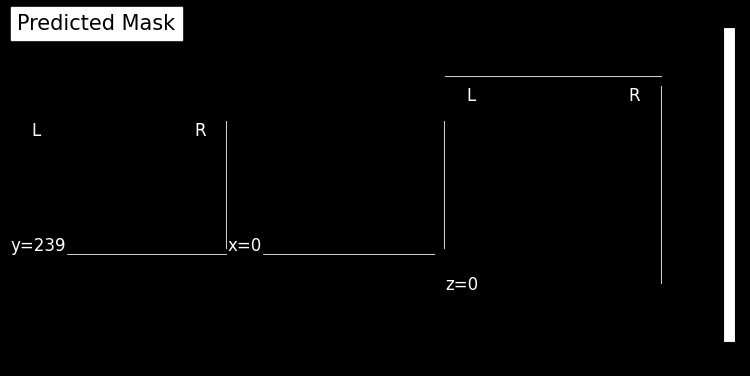

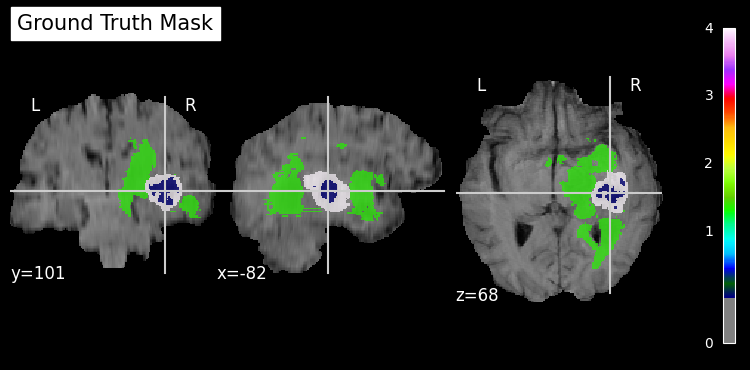

image = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_CBICA_AZD_1/Brats18_CBICA_AZD_1_t1.nii
pred_mask = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_CBICA_AZD_1.nii.gz
gnd_truth_mask = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_CBICA_AZD_1/Brats18_CBICA_AZD_1_seg.nii


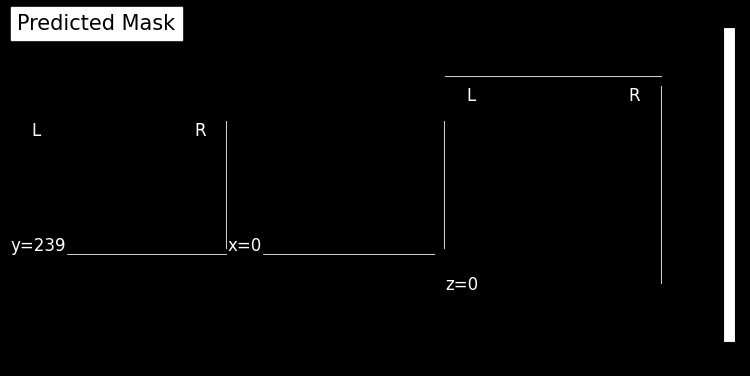

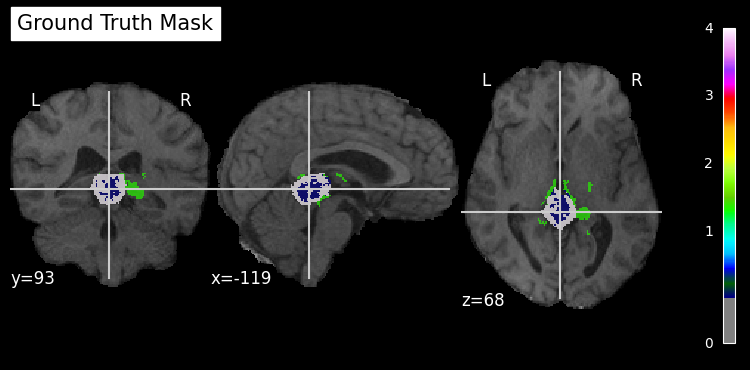

image = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_t1.nii
pred_mask = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_2013_11_1.nii.gz
gnd_truth_mask = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_2013_11_1/Brats18_2013_11_1_seg.nii


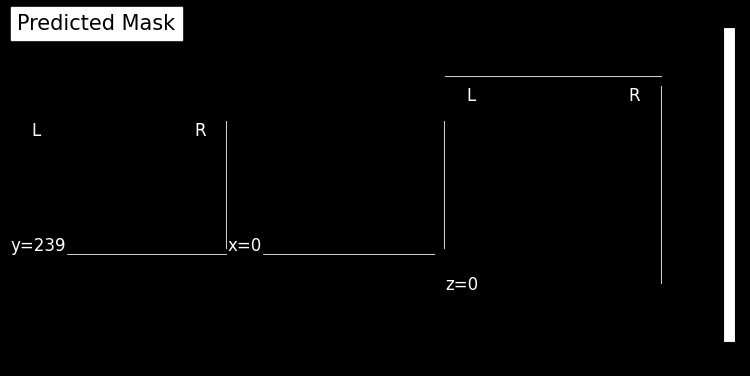

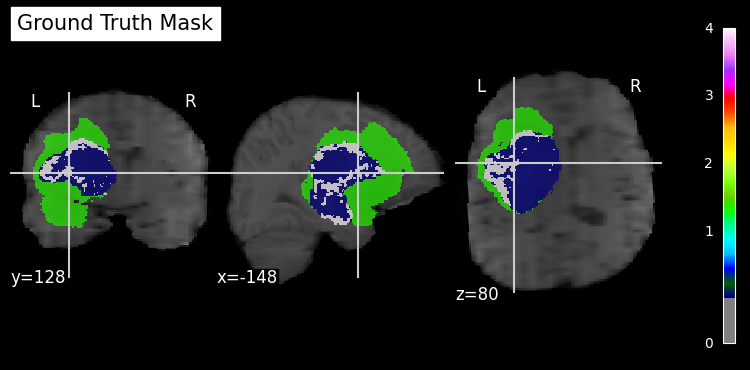

image = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_t1.nii
pred_mask = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA01_221_1.nii.gz
gnd_truth_mask = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA01_221_1/Brats18_TCIA01_221_1_seg.nii


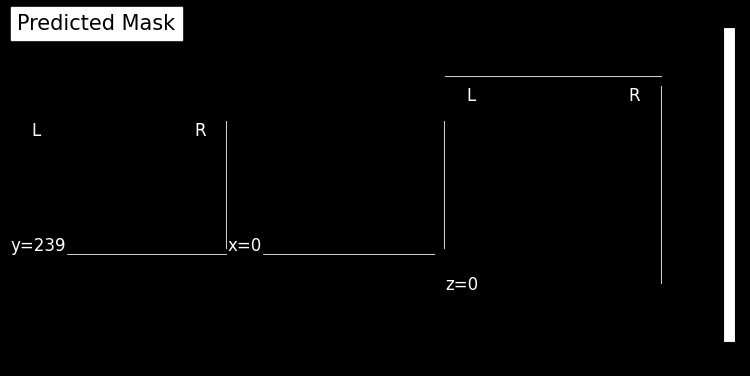

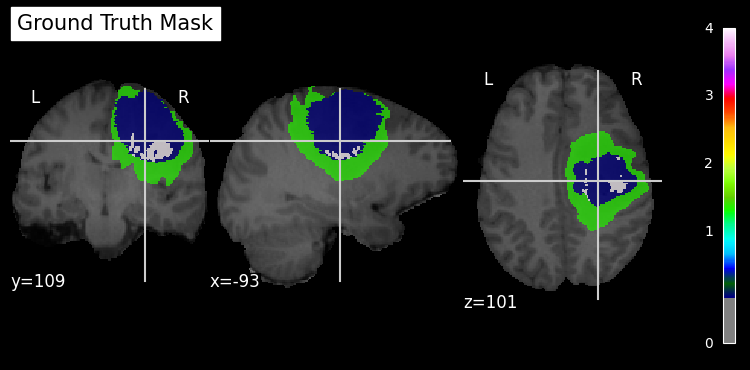

image = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA03_296_1/Brats18_TCIA03_296_1_t1.nii
pred_mask = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSDiceLoss/inferences/pred_Brats18_TCIA03_296_1.nii.gz
gnd_truth_mask = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA03_296_1/Brats18_TCIA03_296_1_seg.nii


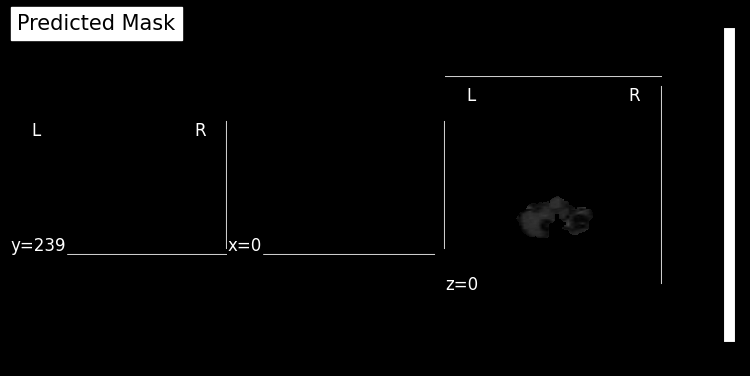

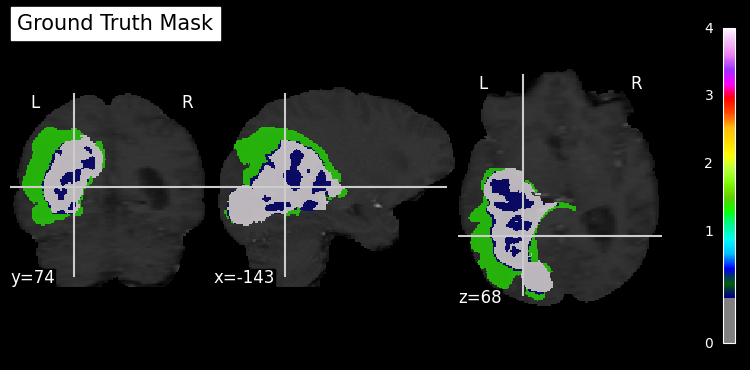

==== Cross Entropy Loss ===
image = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_2013_14_1/Brats18_2013_14_1_t1.nii
pred_mask = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_2013_14_1.nii.gz
gnd_truth_mask = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_2013_14_1/Brats18_2013_14_1_seg.nii


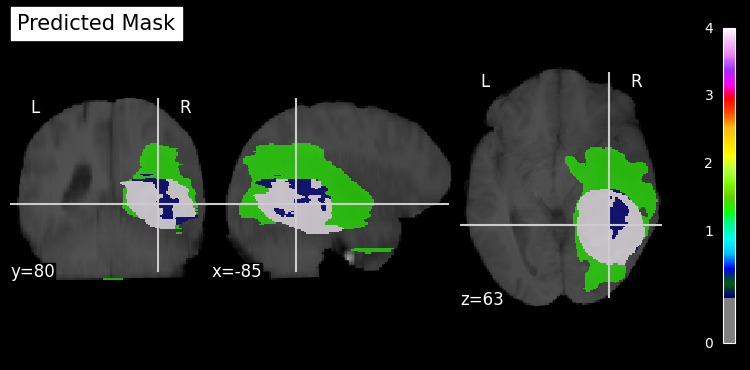

KeyboardInterrupt: 

In [65]:
assert(len(gnd_truth_masks) == len(img_files))
assert(len(pred_masks) == len(img_files))

print(f"Number of images = {len(img_files)}")
print(f"Number of ground truth masks = {len(gnd_truth_masks)}")
print(f"Number of predicted masks = {len(pred_masks)}")

print("===========================")
print("==== Dics Loss ===")
print("===========================")

for i in range(5):
  random_num = random.randint(0, len(img_files)//2)
  print(f"image = {img_files[random_num]}")
  print(f"pred_mask = {pred_masks[random_num]}")
  print(f"gnd_truth_mask = {gnd_truth_masks[random_num]}")
  # print(f"gnd truth shape = {nib.load(gnd_truth_masks[random_num]).get_fdata().shape}")
  # print(f"pred shape = {nib.load(pred_masks[random_num]).get_fdata().shape}")
  # print(f"gnd truth header = {nib.load(gnd_truth_masks[random_num]).header['dim']}")
  # print(f"pred header = {nib.load(pred_masks[random_num]).header['dim']}")
  visualize_mri(pred_masks[random_num], img_files[random_num],title='Predicted Mask')
  visualize_mri(gnd_truth_masks[random_num], img_files[random_num], title = 'Ground Truth Mask')

==== Cross Entropy Loss ===
image = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA03_474_1/Brats18_TCIA03_474_1_t1.nii
pred_mask = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA03_474_1.nii.gz
gnd_truth_mask = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA03_474_1/Brats18_TCIA03_474_1_seg.nii


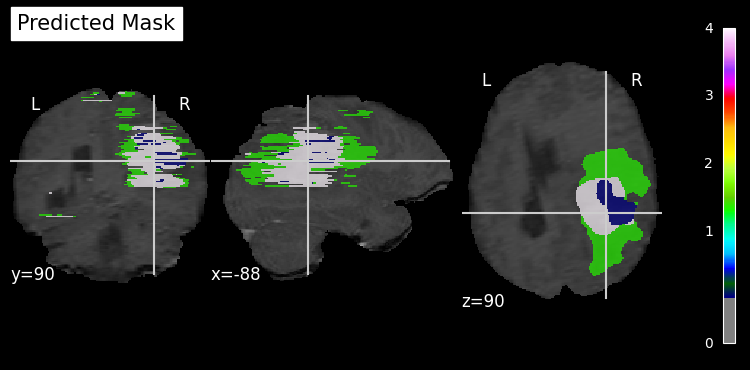

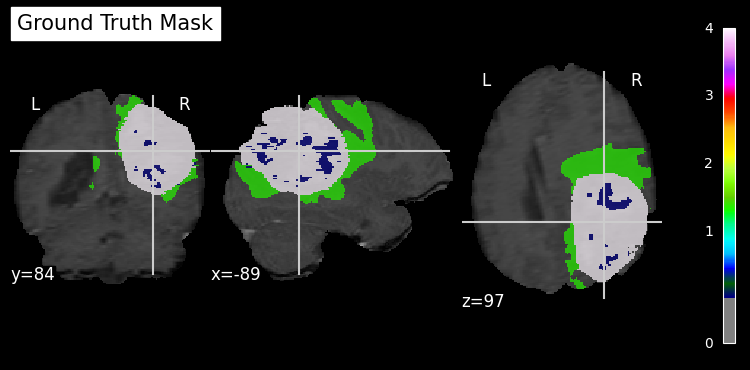

image = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA01_203_1/Brats18_TCIA01_203_1_t1.nii
pred_mask = /content/gdrive/MyDrive/dhai/checkpoints/2025-09-05/BraTSCrossEntropyLoss/inferences/pred_Brats18_TCIA01_203_1.nii.gz
gnd_truth_mask = /content/MICCAI_BraTS_2018_Data_Training/training/HGG/Brats18_TCIA01_203_1/Brats18_TCIA01_203_1_seg.nii


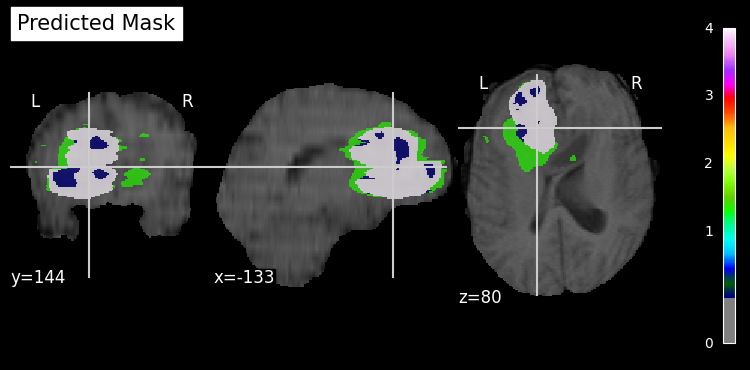

In [ ]:
print("===========================")
print("==== Cross Entropy Loss ===")
print("===========================")

for i in range(5):
  random_num = random.randint(len(img_files)//2, len(img_files)-1)
  print(f"image = {img_files[random_num]}")
  print(f"pred_mask = {pred_masks[random_num]}")
  print(f"gnd_truth_mask = {gnd_truth_masks[random_num]}")
  # print(f"gnd truth shape = {nib.load(gnd_truth_masks[random_num]).get_fdata().shape}")
  # print(f"pred shape = {nib.load(pred_masks[random_num]).get_fdata().shape}")
  # print(f"gnd truth header = {nib.load(gnd_truth_masks[random_num]).header['dim']}")
  # print(f"pred header = {nib.load(pred_masks[random_num]).header['dim']}")
  visualize_mri(pred_masks[random_num], img_files[random_num],title='Predicted Mask')
  visualize_mri(gnd_truth_masks[random_num], img_files[random_num], title = 'Ground Truth Mask')